### Machine Learning (C24), Spring 2024, Project Group F
-----
# Linear Regression Models
This notebook fits linear regression models for the dataset at **df_clean.csv** and outputs a comparative data table of common regression (y-num) metrics.

Data
- y target is `'price actual'`
- X features
    - given: national energy data, weather features from five cities (one-hot-encoded)
    - extracted: tume variables, previous three hours of `'price actual'`

Models fitted (scikit-learn):
-  `DummyRegressor` (for baseline metrics)
1. `LinearRegression` (OLS)
2. `Ridge`
3. `Lasso`

Evaluation metrics:
1. MSE, RMSE, R$^2$, MAE, MAPE
2. Plots: y vs. $\hat{y}$, residuals vs. $\hat{y}$, residual historgram, Bias-Variance Tradeoff: MSE vs. alpha
3. Feature importance (coefficients)

In [1]:
# Import libraries
import pandas as pd
import numpy as np 

from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error
#from sklearn.model_selection import train_test_split, cross_val_score, KFold
#from sklearn.pipeline import make_pipeline

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Import project functions
import sys
sys.path.append('../')
from functions import prep_split, add_model_eval, model_eval_plot, regression_coef_plot

In [2]:
# Output options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Data Preparation

Steps:
1. Drop unneeded columns ⬅️ try options
2. Split X/y, train/test
3. Standardize X

In [3]:
df = pd.read_csv('../Data/df_clean.csv', index_col="time", parse_dates=['time'])
df.shape #(35061, 91)

(35061, 91)

In [4]:
# 1a. Options: try column subsets
price_prev_cols = [col for col in df.columns if 'price_prev' in col]
time_cols = ['hour', 'weekday', 'month']
generation_cols = [col for col in df.columns if 'generation' in col or 'forecast' in col or 'load' in col]
weather_ohe_cols = [col for col in df.columns if 'weather' in col]
ahead_cols = [col for col in df.columns if 'ahead' in col]

# 1b. Option: use top 10 feature importances from xGBoost
xg_top10 = ['price_prev_1', 'price day ahead', 'hour', 'price_prev_2', 'price_prev_3', 'forecast solar day ahead', 'generation solar', 'generation other renewable', 'temp_Madrid', 'temp_Seville', 'price actual']
df2 = df[xg_top10]
df2.shape #(35061, 11)

(35061, 11)

In [5]:
# 2/3. "prep_split" includes dropping specified columns, then standardizing all remaining X (but not y)
y_col = ['price actual']
X_train, X_test, y_train, y_test = prep_split(df,
                                              columns_drop=y_col, #default: just drop y from X
                                              label=y_col,
                                              train_end_date='2017-12-31 23:00:00+00:00',
                                              hours_ahead=0) #default: don't shift y

#X_train.describe() #check: all vars have mean~0, std~1
#y_train.describe() #check: not standardized

In [6]:
# Setup model evaluation dictionary
model_eval = dict()

## 0. Baseline Dummy
- Uses scikit-learn `DummyRegressor`

In [7]:
# Baseline "dummy" prediction based on y-train mean
#y_pred_dummy = pd.Series([y_train.mean()] * len(y_test), index=y_test.index)
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(X_train, y_train)
y_pred_dummy = dummy_model.predict(X_test)

# Calculate Test MSE etc.
model_eval = add_model_eval(model_eval, 'dummy_y0_mean', y_test, y_pred_dummy)
pd.DataFrame(model_eval).T

,MSE,RMSE,R2,MAE,MAPE
dummy_y0_mean,204.00324,14.28297,-0.368643,11.953448,0.212781


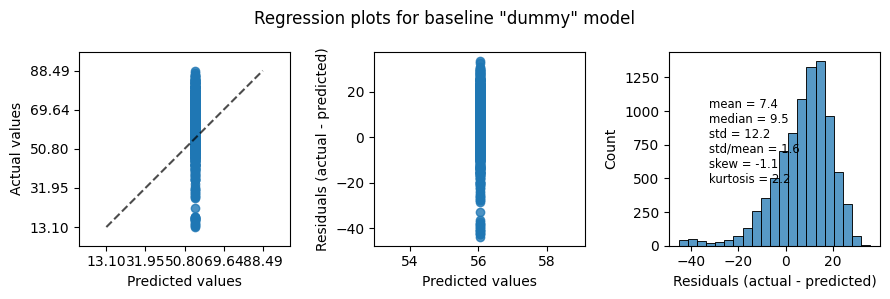

In [8]:
# Key regression plots
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
model_eval_plot(y_test, y_pred_dummy, fig, axes, 'Regression plots for baseline "dummy" model')

## 1. Ordinary Least Squares
Try two iterations:
1. Original: Without extracted time nor previous price features
2. Extracted: Only extracted time nor previous price features
2. Full: original with extracted

In [9]:
# Remove extracted variables
X_train1 = X_train.drop(columns=price_prev_cols+time_cols)
X_test1 = X_test.drop(columns=price_prev_cols+time_cols)

# 1. Create model
ols_model1 = LinearRegression() 
# 2. Fit model with training data
ols_model1.fit(X_train1, y_train)
# Check MSE-train
mean_squared_error(y_train, ols_model1.predict(X_train1))

71.09804892172373

In [10]:
# 3. Use model to predict test data
y_pred_ols1 = ols_model1.predict(X_test1)
# 4a. Evaluate
model_eval = add_model_eval(model_eval, 'Linear Regression (OLS) - original', y_test, y_pred_ols1)
pd.DataFrame(model_eval).T

,MSE,RMSE,R2,MAE,MAPE
dummy_y0_mean,204.003240,14.28297,-0.368643,11.953448,0.212781
Linear Regression (OLS) - original,68.695751,8.28829,0.539125,5.687431,0.105614


In [11]:
# Extracted variables only
X_train2 = X_train[price_prev_cols+time_cols]
X_test2 = X_test[price_prev_cols+time_cols]

# 1. Create model
ols_model2 = LinearRegression() 
# 2. Fit model with training data
ols_model2.fit(X_train2, y_train)
# Check MSE-train
mean_squared_error(y_train, ols_model2.predict(X_train2))

9.90462604605247

In [12]:
# 3. Use model to predict test data
y_pred_ols2 = ols_model2.predict(X_test2) 
# 4a. Evaluate
model_eval = add_model_eval(model_eval, 'Linear Regression (OLS) - extracted', y_test, y_pred_ols2)
pd.DataFrame(model_eval).T

,MSE,RMSE,R2,MAE,MAPE
dummy_y0_mean,204.003240,14.282970,-0.368643,11.953448,0.212781
Linear Regression (OLS) - original,68.695751,8.288290,0.539125,5.687431,0.105614
Linear Regression (OLS) - extracted,7.883807,2.807812,0.947108,1.907896,0.033622


In [13]:
# All variables

# 1. Create model
ols_model3 = LinearRegression() 
# 2. Fit model with training data
ols_model3.fit(X_train, y_train)
# Check MSE-train
mean_squared_error(y_train, ols_model3.predict(X_train))

9.059619684477262

In [14]:
# 3. Use model to predict test data
y_pred_ols3 = ols_model3.predict(X_test) 
# 4a. Evaluate
model_eval = add_model_eval(model_eval, 'Linear Regression (OLS) - full', y_test, y_pred_ols3)
pd.DataFrame(model_eval).T

,MSE,RMSE,R2,MAE,MAPE
dummy_y0_mean,204.003240,14.282970,-0.368643,11.953448,0.212781
Linear Regression (OLS) - original,68.695751,8.288290,0.539125,5.687431,0.105614
Linear Regression (OLS) - extracted,7.883807,2.807812,0.947108,1.907896,0.033622
Linear Regression (OLS) - full,7.797218,2.792350,0.947689,1.974839,0.035338


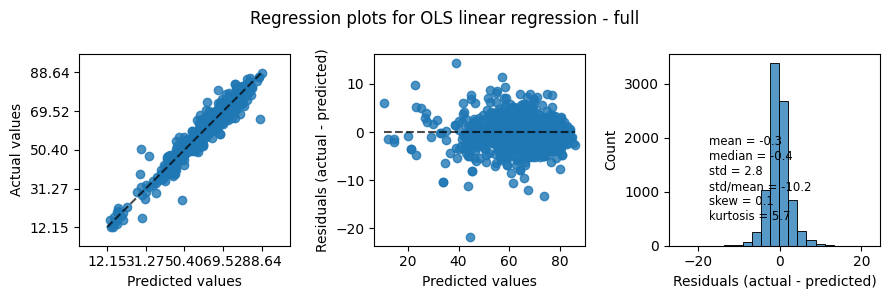

In [15]:
# 4b. Plot
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
model_eval_plot(y_test, y_pred_ols3, fig, axes, 'Regression plots for OLS linear regression - full')

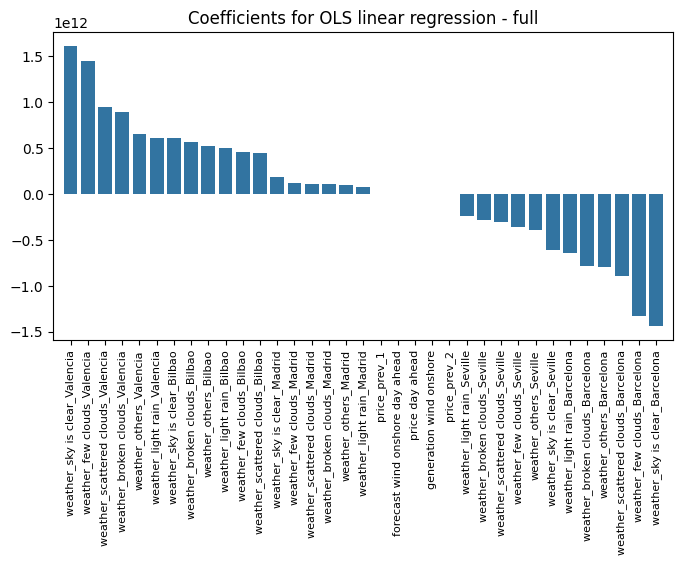

In [16]:
# 4c. Interpret
fig, axes = plt.subplots(figsize=(8, 4))
regression_coef_plot(ols_model3, fig, axes, 1, 'Coefficients for OLS linear regression - full')

## 2. Ridge Regression

In [17]:
# Auto-CV
alphas = np.logspace(-5, 5, 20)
ridge_model = RidgeCV(alphas=alphas, cv=5, scoring='neg_mean_squared_error')
ridge_model.fit(X_train, y_train) 
print(f'Best ridge alpha is: {ridge_model.alpha_} with MSE of {ridge_model.best_score_}')

# Check MSE-train vs. MSE-test
mean_squared_error(y_train, ridge_model.predict(X_train))

Best ridge alpha is: 1e-05 with MSE of -9.844743446330071


9.055803913793538

In [18]:
# Manual looping
#ridge_eval = {'alpha': [], 'mse': []}
#for alpha in np.logspace(-4, 4, 20):
#    ridge_model = Ridge(alpha=alpha) # 1. Create model
#    ridge_model.fit(X_train, y_train)  # 2. Fit model with training data
#    y_pred_ridge = ridge_model.predict(X_test)  # 3. Use model to predict test data
#    mse = mean_squared_error(y_test, y_pred_ridge)  # Calculate MSE
#    
#    ridge_eval['alpha'].append(alpha) # Store alpha
#    ridge_eval['mse'].append(mse) # Store MSE
#
#df_ridge_eval = pd.DataFrame(ridge_eval)
#sns.lineplot(data=df_ridge_eval, x='alpha', y='mse')

In [19]:
# 4a. Evaluate
y_pred_ridge = ridge_model.predict(X_test)
model_eval = add_model_eval(model_eval, 'Ridge Regression', y_test, y_pred_ridge)
pd.DataFrame(model_eval).T

,MSE,RMSE,R2,MAE,MAPE
dummy_y0_mean,204.003240,14.282970,-0.368643,11.953448,0.212781
Linear Regression (OLS) - original,68.695751,8.288290,0.539125,5.687431,0.105614
Linear Regression (OLS) - extracted,7.883807,2.807812,0.947108,1.907896,0.033622
Linear Regression (OLS) - full,7.797218,2.792350,0.947689,1.974839,0.035338
Ridge Regression,7.702118,2.775269,0.948327,1.954686,0.034980


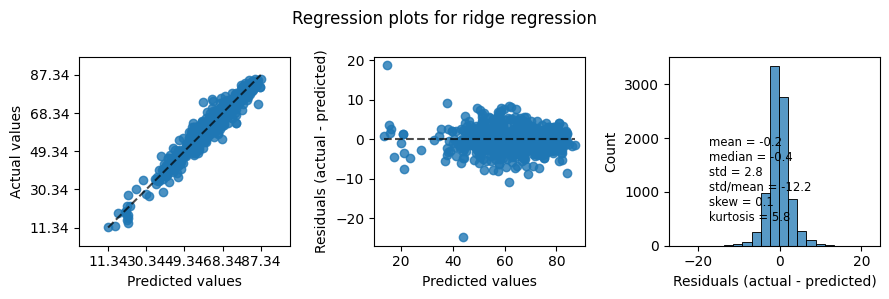

In [20]:
# 4b. Plot
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
model_eval_plot(y_test, y_pred_ridge, fig, axes, 'Regression plots for ridge regression')

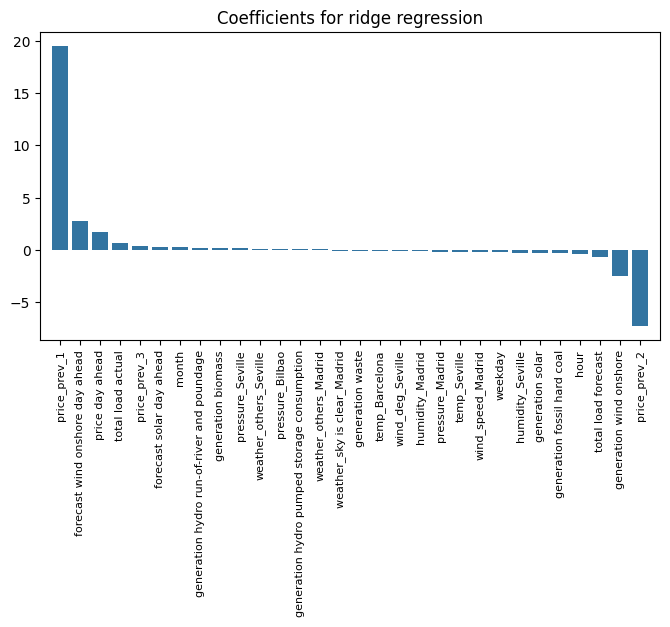

In [21]:
# 4c. Interpret
fig, axes = plt.subplots(figsize=(8, 4))
regression_coef_plot(ridge_model, fig, axes, 0.1, 'Coefficients for ridge regression')

## 3. Lasso Regression

In [22]:
# Auto-CV
alphas = np.logspace(-5, 5, 20)
lasso_model = LassoCV(alphas=alphas, cv=5)
lasso_model.fit(X_train, y_train) 
# Check MSE-train vs. MSE-test
mean_squared_error(y_train, lasso_model.predict(X_train))
print(f'Best lasso alpha is: {lasso_model.alpha_}')

Best lasso alpha is: 0.01438449888287663


In [23]:
# 4a. Evaluate
y_pred_lasso = lasso_model.predict(X_test)
model_eval = add_model_eval(model_eval, 'Lasso Regression', y_test, y_pred_lasso)
pd.DataFrame(model_eval).T

,MSE,RMSE,R2,MAE,MAPE
dummy_y0_mean,204.003240,14.282970,-0.368643,11.953448,0.212781
Linear Regression (OLS) - original,68.695751,8.288290,0.539125,5.687431,0.105614
Linear Regression (OLS) - extracted,7.883807,2.807812,0.947108,1.907896,0.033622
Linear Regression (OLS) - full,7.797218,2.792350,0.947689,1.974839,0.035338
Ridge Regression,7.702118,2.775269,0.948327,1.954686,0.034980
Lasso Regression,7.369148,2.714617,0.950561,1.869095,0.033410


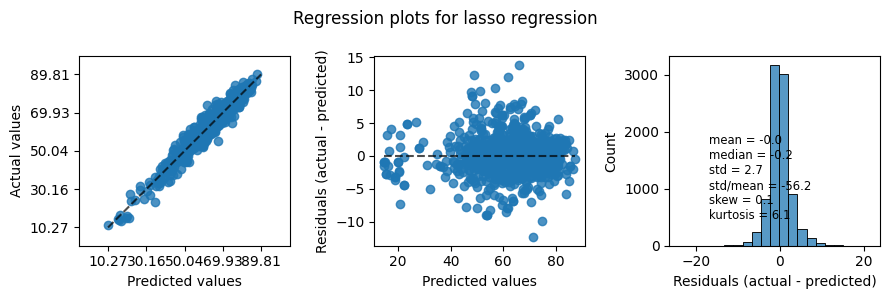

In [24]:
# 4b. Plot
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
model_eval_plot(y_test, y_pred_lasso, fig, axes, 'Regression plots for lasso regression')

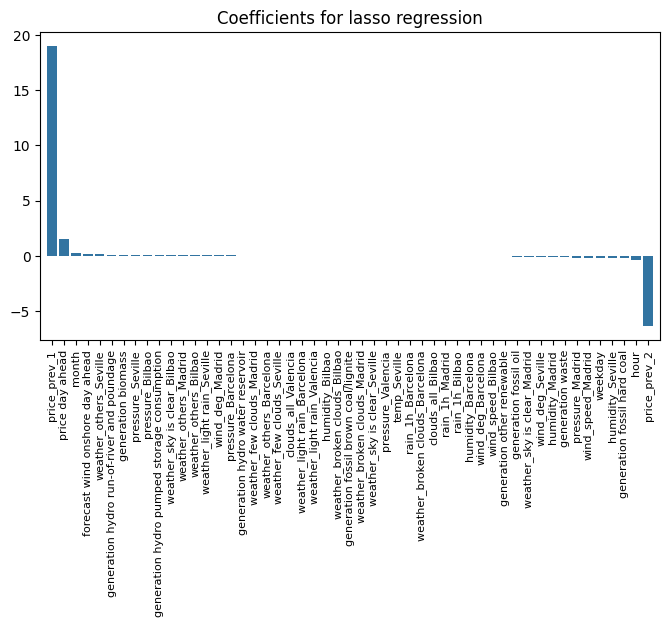

In [25]:
# 4c. Interpret
fig, axes = plt.subplots(figsize=(8, 4))
regression_coef_plot(lasso_model, fig, axes, 1e-10, 'Coefficients for lasso regression')

### Commentary
**Observations:**
- Using the extracted time and previous price variables instead of the original dataset variables dramatically lowers the **RMSE** from 8.29 to 2.81 with OLS linear regression
- Combining all variables shows only a slight improvement to 2.79
- As expected, Ridge and Lasso regressions successively reduce the RMSE from 2.79 to 2.77 to 2.71

**Analysis:**
- As expected, previous prices are the most useful to predict current price